## Machine Learning Project to build a Movie Recommendation System

## <font color=green> Executive Summary </font>

### The overall goal of this project is the implementation of several machine learning algorithms to build movie recommendation systems for users of the system.


## <font color=green> Datasets </font>
### The datasets used in this project is the MovieLens datasets. This is one of the many movie datasets provided by GroupLens. They contain information on movies and their features, such as the title, runtime, budget, languages produced in etc. Other datasets used were the ratings dataset which contained the user ID, movie ID and user rating. These datasets were linked to one another by a third dataset which contained a movie's IMDb ID, TMDb ID and movie ID. 


## <font color=green> EDA </font>

### - Initially, an Exploratory Data Analysis was performed on the datasets. <br> - This involved checking the data types of all features in the movie dataset, changing runtime and revenue occurances of 0 to NaNs as a movie that had already been released would have gotten some value geater than 0 for each of these features. <br>  - Features such as Popularity and vote count had non-numeric values in them and hence were converted to NaNs to indicate unavailable information in those cells. <br> - Then the numerical features were standardized to compare the range of values in a boxplot. <br> - Then features such as revenue, runtime, budget, popularoty and vote averages were fed into a correlation plot to check for any underlyring relationships between variables. <br> - A barplot was plotted to view the number of movies produced in each language to get a sense of which languages were present in the movies and what could be expected from the recommendations.<br>  - From the movies dataset, data was grouped by each movie to understand how many ratings each movie received and what was the average rating received from all users. <br> - This gave a good understanding of the most rated movies and what could show up in recommendations. <br> - A distribution plot of rating averages was plotted for all movies to get a sense of rating behaviours of all users ( most ratings were between 3.25 and 4.25).

## <font color=green> Algorithms </font>

### <font color=green> K-Nearest Neighbours </font>
### The ml-100k data is used in this case. The K-nearest neighbours uses Correlation as the similarity metric. The active user's average rating is used as the starting point. Then the sum of the ratings given by these k-nearest neighbours of the active user asjusted by their mean rating is added to this starting point. This is the predicted rating for a movie that the active user has not seen. 

### <font color=green> Latent-factor based model </font>
### This method is based on matrix factorization and decomposes the user-movie rating matrix to predict a movie that an active user has not seen. The decomposition of the user-movie rating matrix is based on rating values that are not null. This eliminates the issue of having a sparse matrix.

### <font color=green> SVD using Surprise library </font>
### Singular Value Decomposition is based on Matrix Factorization but in this case the Surprise library uses a different method to decompose the user-movie matrix. The SVD++ method is used as an evaluation is performed of all available algorithms based on a 5-fold cross-validation using the RMSE metric. Using this algorithm, predictions are calculated for all movies that a user has not seen/rated yet and the top n recommendations are given out based on how many recommendations the user wants to see. 

### <font color=green> Apriori algorithm </font>
### This algorithm is to show associations between movies and recommend movies that are associated based on other movies chosen by the user. Support and Confidence are the two metrics used to decide associations between movies.
    

### First, I will start with an EDA of the movie database datasets to get an understanding of various aspects of the datasets. The dataset used here was obtained on Kaggle using the TMDb Open API and the GroupLens dataset.

In [1]:
# Libraries to import
import numpy as np
import scipy.stats as stats
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from collections import defaultdict
import missingno as msno
from IPython.display import Image, HTML
from scipy.spatial.distance import correlation
import itertools
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, accuracy, NormalPredictor, NMF, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
sns.set(style = 'white', color_codes=True)

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [2]:
# Importing the movie database dataset which contains features to understand the language, which country the movie was produced
# the votes it received among others
movies_df = pd.read_csv('./movies_metadata.csv')
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSE,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,30-10-1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,FALSE,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,15-12-1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,FALSE,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,22-12-1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,FALSE,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,22-12-1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,FALSE,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,10-02-1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Shape of the dataframe
movies_df.shape

(45466, 24)

In [4]:
# Feature dtypes to understand which are the numerical columns we have
movies_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [5]:
# Summary statistics on the numerical features of the movies dataframe
movies_df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


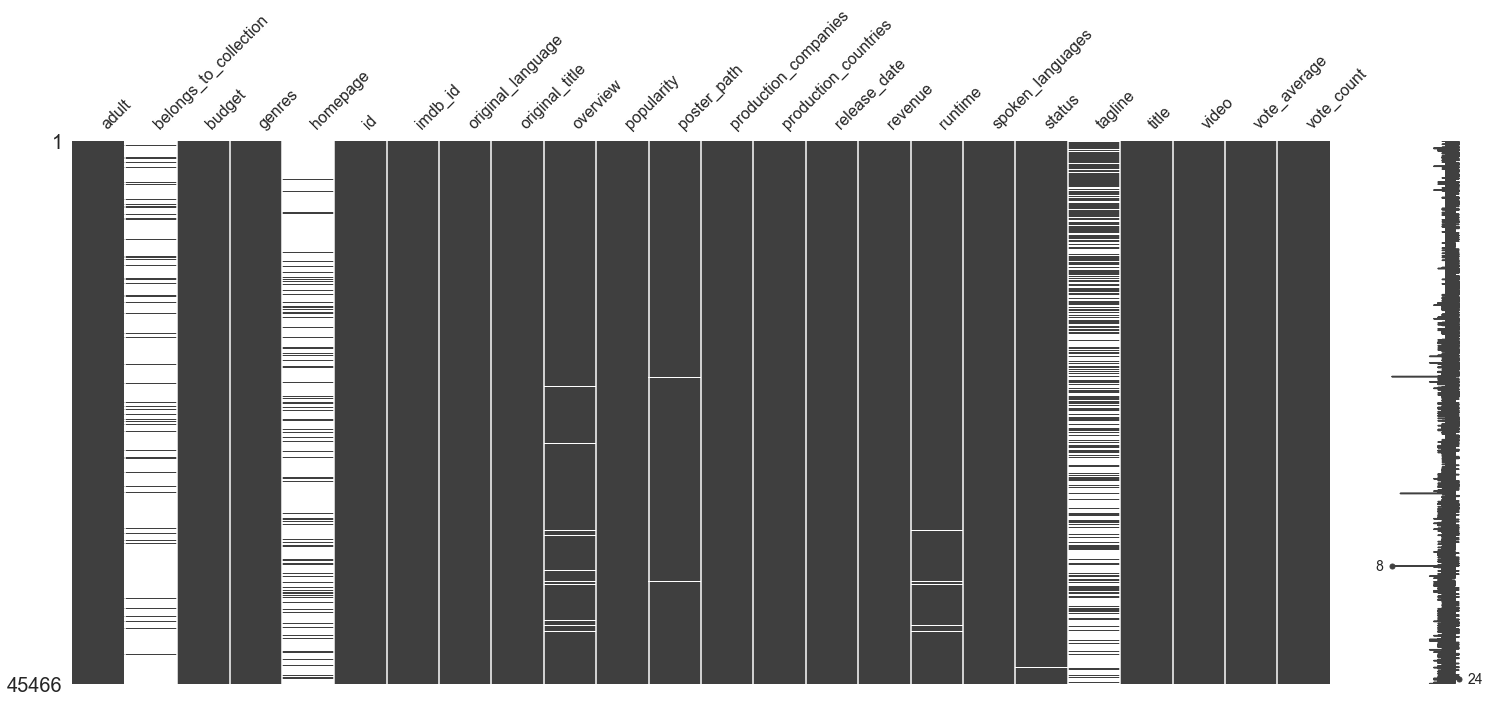

In [6]:
# Since the count is different for the numerical features, checking for data sparsity in the dataframe
msno.matrix(movies_df)

In [7]:
# Checking for null values in the dataframe
movies_df.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [8]:
# Based on the summary statistics, it can be seen that revenue and run-time have minimum values as 0 
# which is not possible. We will explore this more and then decide how to handle their 0 values
movies_df['revenue'].value_counts()

0.0            38052
12000000.0        20
10000000.0        19
11000000.0        19
2000000.0         18
6000000.0         17
5000000.0         14
8000000.0         13
500000.0          13
14000000.0        12
1.0               12
7000000.0         11
20000000.0        10
1000000.0         10
3000000.0         10
1500000.0          9
4000000.0          9
3.0                9
2500000.0          8
4100000.0          8
25000000.0         8
16000000.0         8
30000000.0         8
15000000.0         8
4300000.0          7
18000000.0         7
13000000.0         7
1400000.0          6
100000000.0        6
9000000.0          6
               ...  
26533200.0         1
40485039.0         1
122915111.0        1
80936232.0         1
161849455.0        1
245676146.0        1
18130888.0         1
316000.0           1
29450919.0         1
6629178.0          1
89289910.0         1
1133031.0          1
20225989.0         1
40452643.0         1
26518355.0         1
57231524.0         1
10113733.0   

In [9]:
movies_df['runtime'].value_counts()

90.0      2556
0.0       1558
100.0     1470
95.0      1412
93.0      1214
96.0      1104
92.0      1080
94.0      1062
91.0      1057
88.0      1032
97.0      1027
85.0      1024
98.0      1019
105.0     1002
89.0       958
87.0       919
110.0      850
86.0       846
99.0       794
102.0      791
104.0      740
103.0      739
80.0       736
101.0      705
84.0       700
83.0       606
108.0      603
106.0      596
120.0      591
107.0      589
          ... 
440.0        1
336.0        1
268.0        1
931.0        1
283.0        1
540.0        1
480.0        1
288.0        1
281.0        1
585.0        1
251.0        1
357.0        1
452.0        1
501.0        1
353.0        1
298.0        1
395.0        1
286.0        1
211.0        1
285.0        1
874.0        1
388.0        1
232.0        1
338.0        1
551.0        1
238.0        1
316.0        1
258.0        1
780.0        1
1256.0       1
Name: runtime, Length: 353, dtype: int64

In [10]:
# Changing 0s to NaNs.
movies_df['revenue'] = movies_df['revenue'].replace(0, np.nan)
movies_df['runtime'] = movies_df['runtime'].replace(0, np.nan)

In [11]:
# Function to convert non-numeric values to NaN
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [12]:
# Converting the values in the Popularity, vote_count and vote_average column to make sure they have either 
# numbers or NaNs
movies_df['popularity'] = movies_df['popularity'].apply(clean_numeric).astype('float')
movies_df['vote_count'] = movies_df['vote_count'].apply(clean_numeric).astype('float')
movies_df['vote_average'] = movies_df['vote_average'].apply(clean_numeric).astype('float')

In [13]:
# Since budget has a few text entries instead of numbers, we will deal with them here
# and convert the column from Object to numeric type
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['budget'] = movies_df['budget'].replace(0, np.nan)
#movies_df[movies_df['budget'].isnull()].shape

In [14]:
# Checking the value count of the adult column
movies_df['adult'].value_counts()

FALSE                                                                                                                             45454
TRUE                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
Name: adult, dtype: int64

In [15]:
# Dropping the adult column as it contains limited information to use
movies_df.drop('adult', axis=1, inplace=True)

Text(0.5, 1.0, 'Box plots with standardized numeric features')

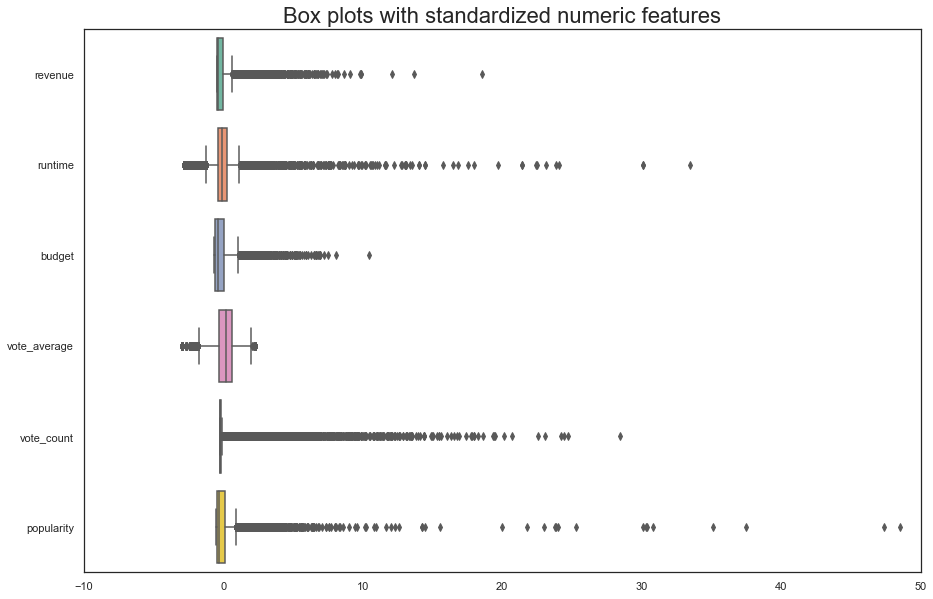

In [16]:
# Standardizing the numerical features and showing them in box-plots
# with each other
# It can be seen that there are no outliers. There seems to be one in the Revenue feature which will be explored next

num_df = pd.DataFrame()
revenue = (movies_df['revenue'] - np.mean(movies_df['revenue']))/np.std(movies_df['revenue'])
runtime = (movies_df['runtime'] - np.mean(movies_df['runtime']))/np.std(movies_df['runtime'])
budget = (movies_df['budget'] - np.mean(movies_df['budget']))/np.std(movies_df['budget'])
popularity = (movies_df['popularity'] - np.mean(movies_df['popularity']))/np.std(movies_df['popularity'])
vote_average = (movies_df['vote_average'] - np.mean(movies_df['vote_average']))/np.std(movies_df['vote_average'])
vote_count = (movies_df['vote_count'] - np.mean(movies_df['vote_count']))/np.std(movies_df['vote_count'])
num_df['revenue'] = revenue
num_df['runtime'] = runtime
num_df['budget'] = budget
num_df['vote_average'] = vote_average
num_df['vote_count'] = vote_count
num_df['popularity'] = popularity

#ax = num_df[['revenue','runtime', 'vote_average', 'vote_count']].plot(kind='box', figsize=(10,10), colormap='viridis')
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=num_df, orient="h", palette="Set2")
ax.set(xlim=(-10, 50))
ax.set_title('Box plots with standardized numeric features', fontsize=22)

In [17]:
# Exploring the data to see the row with the really large Revenue
# It can be seen that this row belongs to Avatar which indeed did have that large a revenue
movies_df[movies_df['revenue'] == 2787965087.0]

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
14551,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.070892,...,10-12-2009,2.787965e+09,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.2,12114.0


In [18]:
# Exploring data with runtime=1
# On observation it can be seen that they are short films from years ago
movies_df[movies_df['runtime'] == 1]

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
16252,NaN,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,49296,tt0135696,fr,Un homme de têtes,One of the greatest of black art pictures. The...,0.966366,...,1898-01-01,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,The Four Troublesome Heads,False,6.8,19.0
16257,NaN,NaN,"[{'id': 14, 'name': 'Fantasy'}]",NaN,195311,tt0226350,en,La pyramide de Triboulet,Méliès appears as a court jester (a “triboulet...,0.142316,...,1899-05-20,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,The Human Pyramid,False,5.5,2.0
17332,NaN,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,18888,tt0170232,cs,Zamilované Maso,"Two meaty characters meet, fall in love, and e...",0.003013,...,01-01-1989,NaN,1.0,[],Released,NaN,Meat Love,False,7.3,10.0
17569,NaN,NaN,"[{'id': 99, 'name': 'Documentary'}]",NaN,105158,tt0000008,en,Edison Kinetoscopic Record of a Sneeze,A man (Thomas Edison's assistant) takes a pinc...,0.312246,...,1894-01-09,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,Edison Kinetoscopic Record of a Sneeze,False,4.7,12.0
18914,NaN,NaN,[],NaN,159900,tt0000192,en,"Ella Lola, a la Trilby","A young, dark-haired woman performs a dance in...",0.055116,...,1898-01-01,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,"Ella Lola, a la Trilby",False,4.0,1.0
18944,NaN,NaN,[],NaN,159907,tt0241000,en,"Turkish Dance, Ella Lola","In this movie, dancer Ella Lola performs a Tur...",0.101900,...,1898-09-30,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,"Turkish Dance, Ella Lola",False,4.5,2.0
18960,NaN,NaN,"[{'id': 99, 'name': 'Documentary'}]",NaN,231763,tt0334960,en,"Boys Diving, Honolulu",In the background is a row of three-masted sai...,0.002307,...,01-01-1901,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,"Boys Diving, Honolulu",False,0.0,0.0
19012,NaN,NaN,[],NaN,104396,tt0177707,en,Dickson Experimental Sound Film,William K.L. Dickson plays the violin while tw...,0.493914,...,1894-08-31,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,Dickson Experimental Sound Film,False,6.7,18.0
19138,NaN,NaN,"[{'id': 18, 'name': 'Drama'}]",NaN,16624,tt0000005,xx,Blacksmith Scene,Three men hammer on an anvil and pass a bottle...,1.061591,...,1893-05-08,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,Blacksmith Scene,False,5.8,19.0
19244,NaN,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,94570,tt0139738,en,The Kiss,"They get ready to kiss, begin to kiss, and kis...",0.898166,...,1896-04-01,NaN,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,The Kiss,False,5.0,24.0


In [19]:
# Cleaning the num_df before checking correlation among features
num_df1 = num_df.dropna()
num_df1.shape

(5369, 6)

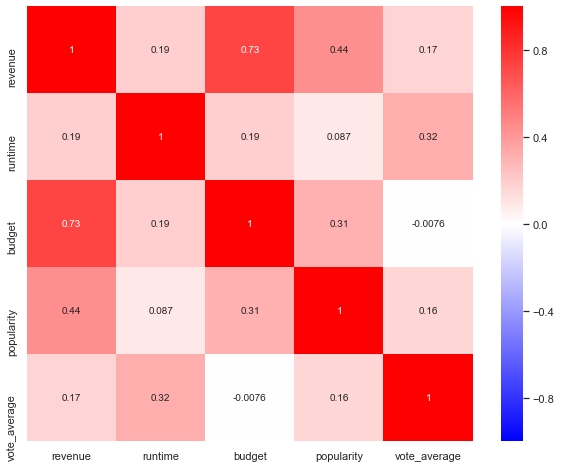

In [20]:
# Checking the correlation of the numerical features to understand their relation among each other and with the
# vote_average received by movies

# It can be seen that there seems to be a strong positive correlation between budget and revenue

fig, ax = plt.subplots(figsize=(10,8))  
sns.heatmap(num_df1[['revenue', 'runtime', 'budget', 'popularity', 'vote_average']].corr(), vmin = -1, vmax = 1, cmap= 'bwr',annot= True, ax=ax )


In [21]:
# Checking what the poster paths of movies are like. They need to be given their complete paths
print(movies_df['poster_path'][0])

# Adding the poster path obtained by inspecting the image element on TMDb web page
base_poster_path = 'http://image.tmdb.org/t/p/w185/'
movies_df['poster_path'] = "<img src='" + base_poster_path + movies_df['poster_path'] + "' style='height:100px;'>"
print(movies_df['poster_path'][0])

/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
<img src='http://image.tmdb.org/t/p/w185//rhIRbceoE9lR4veEXuwCC2wARtG.jpg' style='height:100px;'>


In [22]:
# Understanding the languages contained in the movies to get an idea of the different industries involved
language_df = pd.DataFrame(movies_df['original_language'].value_counts())
language_df['language'] = language_df.index
language_df.columns = ['count', 'original_language']
language_df['language'] =  language_df['original_language'].map({'en':'English', 'fr': 'French', 'it': 'Italian', 
                                                                 'ja': 'Japanese', 'de': 'German', 
                                                                 'es': 'Spanish', 'ru': 'Russian', 'hi': 'Hindi', 
                                                                 'ko': 'Korean', 'zh': 'Chinese'
                                                                   })
language_df = language_df.reset_index(drop=True)
language_df.head()

,count,original_language,language
0,32269,en,English
1,2438,fr,French
2,1529,it,Italian
3,1350,ja,Japanese
4,1080,de,German


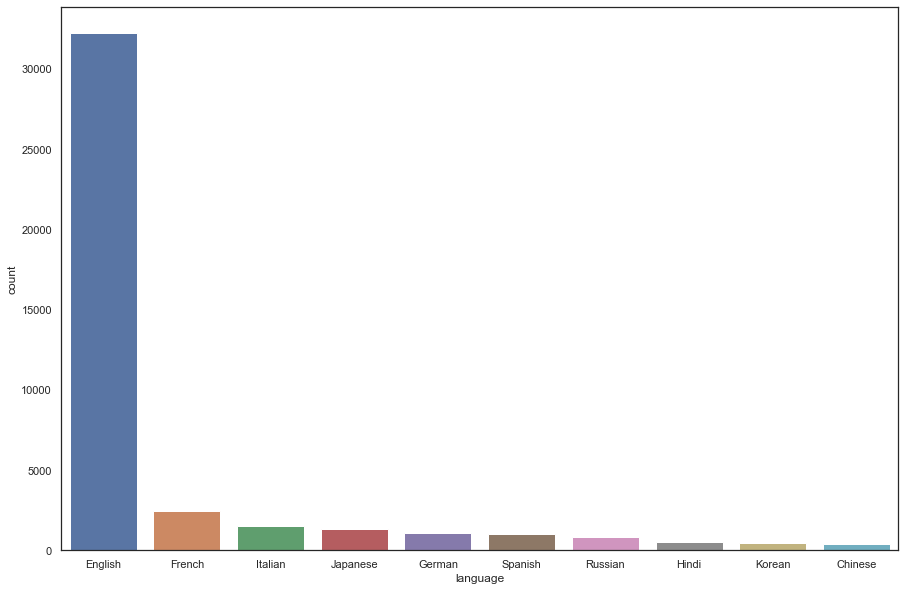

In [23]:
# Plotting the languages in a bar graph to see the top 10 languages of movies
plt.figure(figsize=(15,10))
ax = sns.barplot(x = 'language', y = 'count', data = language_df.head(10))
#labels = ['English', 'French', 'Italian', 'Japanese', 'German', 'Spanish', 'Russian', 'Hindi', 'Korean', 'Chinese'])
plt.show()

### I will now take the intersection of three dataframes. The user rating dataframe has user ratings which has movie ids which will be linked to the links dataframe as this dataframe has links between movie ids and TMDb ids. I will then take an intersection of this dataframe with the movies dataframe. So finally, I will have a dataframe of users and their ratings along with the movie descriptions of all the movies they have rated. 

In [24]:
# Loading two dataframes from csv
links_df = pd.read_csv('./links_small.csv')
ratings_df = pd.read_csv('./ratings_small.csv')

In [25]:
# Changing the datatype of the id feature from the movies dataframe
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
#movies_df['budget'] = movies_df['budget'].replaciid)

In [26]:
# Merging ratings, links and movies dataframes
lr_df = pd.merge(links_df, ratings_df, how='inner', on='movieId')
lr_df.head()
lr_df.columns = ['movieId','imdbId','id','userId','rating','timestamp']
mlr_df = pd.merge(movies_df, lr_df, how='inner', on='id')

In [27]:
# Checking how the dataframes are being inner-joined
print(links_df.shape)
print(ratings_df.shape)
print(lr_df.shape)
print(movies_df.shape)
print(mlr_df.shape)

(9125, 3)
(100004, 4)
(100004, 6)
(45466, 23)
(100063, 28)


In [28]:
mlr_df['original_title'].value_counts()

Forrest Gump                                         341
Pulp Fiction                                         324
The Shawshank Redemption                             311
The Silence of the Lambs                             304
Star Wars                                            291
Jurassic Park                                        274
The Matrix                                           259
Toy Story                                            247
Schindler's List                                     244
Terminator 2: Judgment Day                           237
The Empire Strikes Back                              234
Braveheart                                           228
Back to the Future                                   226
Fargo                                                224
American Beauty                                      220
Raiders of the Lost Ark                              220
Independence Day                                     218
Return of the Jedi             

In [29]:
# Now I will analyse the ratings given to movies by users
crat_df = pd.DataFrame()
crat_df['rating_count'] = mlr_df.groupby('original_title')['rating'].count().sort_values(ascending=False)
crat_df['rating_sum'] = mlr_df.groupby('original_title')['rating'].sum().sort_values(ascending=False)
crat_df['rating_avg'] = mlr_df.groupby('original_title')['rating'].mean().sort_values(ascending=False)
crat1_df = crat_df[crat_df['rating_count'] > 50].sort_values(by=['rating_avg'], ascending=False)
crat1_df = crat1_df.reset_index()
crat2_df = pd.merge(crat1_df, movies_df, how='inner', on='original_title')
crat3_df = crat2_df[['original_title', 'rating_count', 'rating_sum', 'rating_avg', 'poster_path']]
crat3_df = crat3_df.drop_duplicates(subset='original_title')
crat3_df.head(15)
pd.set_option('display.max_colwidth', 100)
HTML(crat3_df.to_html(escape=False))

,original_title,rating_count,rating_sum,rating_avg,poster_path
0,The Godfather,200,897.5,4.487500,
1,The Shawshank Redemption,311,1395.5,4.487138,
2,The Godfather: Part II,135,592.0,4.385185,
3,The Usual Suspects,201,878.5,4.370647,
4,Chinatown,76,329.5,4.335526,
5,The Maltese Falcon,77,333.5,4.331169,
7,Rear Window,92,397.0,4.315217,
9,Schindler's List,244,1050.0,4.303279,
10,Cidade de Deus,69,296.5,4.297101,
11,12 Angry Men,78,335.0,4.294872,


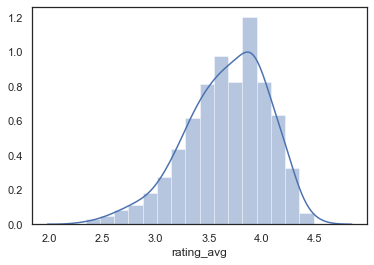

In [30]:
# Distribution of rating average to see the range of rating values obtained by all movies in the ratings csv file
sns.distplot(crat3_df['rating_avg'])

### Now, I will build a Movie Recommendation system using Unsupervised learning techniques. 

### The first algorithm being implemented is user based K-Nearest Neighbour Collaborative Filtering

### This algorithm uses the correlation similarity metric to find k-nearest neighbours of an active user and sums the ratings given by the nearest neighbours adjusted by their respective means to account for bias

In [31]:
dataFile = './ml-100k/u.data'
data = pd.read_csv(dataFile, sep='\t', header=None,
                  names = ['userId', 'itemId', 'rating', 'timestamp'])

In [32]:
# Exploring the DataFrame to see the first five rows
data.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [33]:
# Reading in the movies info file to get the movie names for all movie ids
movieInfoFile = './ml-100k/u.item'
movieInfo = pd.read_csv(movieInfoFile, sep="|", header=None, index_col=False, 
                        names=['itemId', 'title'], usecols=[0,1],
                       encoding='latin-1')

In [34]:
# Exploring the DataFrame to see the first five rows
movieInfo.head()

,itemId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [35]:
# Merging the movies dataframe into the data dataframe
data = pd.merge(data, movieInfo, left_on='itemId', right_on='itemId')
data.head()

,userId,itemId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [36]:
# Sorting the dataframe to list user ids in descending order and 
# movie ids in ascending order
data = pd.DataFrame.sort_values(data, ['userId', 'itemId'], ascending=[0,1])

In [37]:
# Viewing the first five rows of the dataframe
data.head()

,userId,itemId,rating,timestamp,title
23781,943,2,5,888639953,GoldenEye (1995)
65410,943,9,3,875501960,Dead Man Walking (1995)
35098,943,11,4,888639000,Seven (Se7en) (1995)
43773,943,12,5,888639093,"Usual Suspects, The (1995)"
57040,943,22,4,888639042,Braveheart (1995)


In [38]:
# Top N favorite movies of a user
def favoriteMovies(activeUser, N):
    topMovies = pd.DataFrame.sort_values(data[data.userId==activeUser], 
                                         ['rating'], ascending=[0])[:N]
    return list(topMovies.title)

#print(favoriteMovies(5,3))   

In [39]:
# Using pivot table to convert the dataframe into user-rating matrix
userItemRatingMatrix = pd.pivot_table(data, values='rating', 
                                      index=['userId'], columns=['itemId'])

In [40]:
# Viewing the first five rows of the dataframe
userItemRatingMatrix.head()

itemId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Finding correlation between any two users
def similarity(user1, user2):
    user1 = np.array(user1) - np.nanmean(user1)
    user2 = np.array(user2) - np.nanmean(user2)
    commonItemIds = [i for i in range(len(user1)) if user1[i]>0 and 
                    user2[i]>0]
    if len(commonItemIds) == 0:
        return 0
    else:
        user1 = np.array([user1[i] for i in commonItemIds])
        user2 = np.array([user2[i] for i in commonItemIds])
        return correlation(user1, user2)

In [42]:
# Finding the nearest neighbor ratings of the active user
def nearestNeighbourRatings(ActiveUser, K):
    similarityMatrix = pd.DataFrame(index = userItemRatingMatrix.index, 
                                    columns=['Similarity'])
    for i in userItemRatingMatrix.index:
        similarityMatrix.loc[i] = similarity(userItemRatingMatrix.loc[activeUser], 
                                            userItemRatingMatrix.loc[i])
        
    similarityMatrix = pd.DataFrame.sort_values(similarityMatrix,
                                                   ['Similarity'], ascending=[0])
    nearestNeighbours = similarityMatrix[:K]
    
    neighbourItemRatings = userItemRatingMatrix.loc[nearestNeighbours.index]
    
    predictItemRating = pd.DataFrame(index=userItemRatingMatrix.columns, columns=['Rating'])

    for i in userItemRatingMatrix.columns:
        predictedRating = np.nanmean(userItemRatingMatrix.loc[activeUser])
        for j in neighbourItemRatings.index:
            if userItemRatingMatrix.loc[j,i]>0:
                predictedRating += (userItemRatingMatrix.loc[j,i]-
                                    np.nanmean(userItemRatingMatrix.loc[j]))*nearestNeighbours.loc[j,'Similarity']
        predictItemRating.loc[i,'Rating']=predictedRating
    return predictItemRating


In [43]:
# Finding top recommendations based on the nearest neighbour ratings
def topNRecommendations(activeuser, N):
    predictItemRating = nearestNeighbourRatings(activeUser, 10)
    moviesAlreadyWatched = list(userItemRatingMatrix.loc[activeUser]
                               .loc[userItemRatingMatrix.loc[activeuser]>0].index)
    predictItemRating = predictItemRating.drop(moviesAlreadyWatched)
    topRecommendations = pd.DataFrame.sort_values(predictItemRating, ['Rating'],
                                                 ascending=[0])[:N]
    topRecommendationTitles = (movieInfo.loc[movieInfo.itemId.isin(topRecommendations.index)])
    return list(topRecommendationTitles.title)

In [41]:
# Printing top 5 movies of an active user and the top 3 recommendations based on the movies the active user likes
activeUser = 1
print(favoriteMovies(activeUser, 5), "\n", topNRecommendations(activeUser, 3))

NameError: name 'topNRecommendations' is not defined

### Now I will implement Latent-factor based model using Matrix Factorization

### This algorithm finds latent factors for both users and movies and uses those factors to calculate ratings for movies not seen by a user

In [45]:
# Using stochastic gradient descent to find factor vectors
# Gamma is the step size in error correction
# Lambda is the regularization parameter to avoid overfitting

def matrixFactorization(R, K, steps=10, gamma=0.001, lamda=0.02):
    N = len(R.index)
    M = len(R.columns)
    P = pd.DataFrame(np.random.rand(N,K), index=R.index)
    Q = pd.DataFrame(np.random.rand(M,K), index=R.columns)
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij = R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[i]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        
        
     
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e = e + pow(R.loc[i,j] - np.dot(P.loc[i],Q.loc[j]),2) + lamda*(pow(np.linalg.norm(P.loc[i]),2) + pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
           break
        print(step)
    return P,Q
    
(P,Q) = matrixFactorization(userItemRatingMatrix.iloc[:100,:100] , K=2, steps=100, gamma=0.001, lamda=0.02)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [46]:
# Recommending top 3 movies to the active user based on Matrix Factorization
activeUser=1
predictItemRating = pd.DataFrame(np.dot(P.loc[activeUser], Q.T), index=Q.index, columns=['Rating'])
topRecommendations = pd.DataFrame.sort_values(predictItemRating, ['Rating'], ascending=[0])[:3]
topRecommendationTitles = movieInfo.loc[movieInfo.itemId.isin(topRecommendations.index)]
print(list(topRecommendationTitles.title))

['Professional, The (1994)', 'Free Willy (1993)', 'Welcome to the Dollhouse (1995)']


### The third algorithm I am implementing is Collaborative Filtering using the Surprise library

### SVD a form of Matrix Decomposition used here

In [42]:
# Object to parse the data
reader = Reader(rating_scale=(1,5))

In [43]:
# The ratings file used in the Surprise algorithm
ratings = pd.read_csv('./ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [44]:
# Loading the ratings, links csv's to use here
links_df = pd.read_csv('./links_small.csv')
ratings_df = pd.read_csv('./ratings_small.csv')

lr_df = pd.merge(links_df, ratings_df, how='inner', on='movieId')
lr_df.head()
lr_df.columns = ['movieId','imdbId','id','userId','rating','timestamp']
mlr_df = pd.merge(movies_df, lr_df, how='inner', on='id')

In [45]:
# Checking how the merged dataframe looks like
mlr_df.head(1)

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,tagline,title,video,vote_average,vote_count,movieId,imdbId,userId,rating,timestamp
0,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg',...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear o...",21.946943,...,NaN,Toy Story,False,7.7,5415.0,1,114709,7,3.0,851866703


In [46]:
# Loading the required features from the ratings file into the data object
data = Dataset.load_from_df(mlr_df[['userId', 'id', 'rating']],reader)

In [47]:
# Creating the test-train splits of the data
trainset, testset = train_test_split(data, test_size=.25)

In [54]:
# Checking the RMSE of the predictions to measure model accuracy using 5-fold cv
svd = SVD()
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8968
RMSE: 0.8931
RMSE: 0.8943
RMSE: 0.8989
RMSE: 0.9015


#### As can be seen above, the RMSE value is lower than the benchmark accuracy described on the Surprise documentation of 0.934.

In [55]:
# Getting a prediction for a test user
# Parameters are user id, movie id, and actual rating
pred = svd.predict(1, 31, 2.5, verbose=True)

user: 1          item: 31         r_ui = 2.50   est = 2.90   {'was_impossible': False}


In [36]:
# Using Grid search CV before fitting the model on the training set
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that give the best RMSE score
print(gs.best_params['rmse'])

0.9101189193101067
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
# Once the grid search is complete and the best parameters are identified, then the model can be fit
# using the following code
# alg = SVDpp(lr_all=0.001)
# output = surprise.model_selection.cross_validate(alg, data, verbose=True)

In [57]:
# Creating a train set from the whole data to fit the SVD on
trainset = data.build_full_trainset()

In [58]:
# Fitting the SVD on the whole dataset as train set seems to yield a prediction
# estimate not as good as the one implemented above
svd = SVD()
svd.fit(trainset)

# Getting a prediction for a test user
# Parameters are user id, movie id, and actual rating
pred = svd.predict(1, 31, 2.5, verbose=True)

user: 1          item: 31         r_ui = 2.50   est = 2.71   {'was_impossible': False}


In [59]:
# Using User id=1 to see that user's ratings
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [99]:
# Checking which model out of all the choices gives the least RMSE
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.887190,495.760902,10.311615
BaselineOnly,0.893633,0.297783,0.175377
KNNBaseline,0.897327,0.619148,2.369717
SVD,0.897825,5.086562,0.335625
KNNWithZScore,0.917292,0.380758,2.166595
KNNWithMeans,0.919954,0.391372,2.133667
SlopeOne,0.930916,4.557158,6.477149
NMF,0.945171,6.467061,0.219103
CoClustering,0.965306,3.575914,0.214544


#### Now that I understand that my model using Surprise is yielding good results, I will build a model to give out top 10 recommendations. Also from the above benchmarks calculated by testing various models, the SVD++ performs with the lowest RMSE value and hence I will use this to implement the final algorithm.

In [60]:
# Function to get top n predictions for all users
# def get_top_n(predictions, n=10):
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))
    
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]
        
#     return top_n

In [48]:
# Loading the data to train the SVD model and testing on an anti testset
#data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']],reader)
data = Dataset.load_from_df(mlr_df[['userId', 'id', 'rating']],reader)
trainset = data.build_full_trainset()
algo = SVDpp()
algo.fit(trainset)

#testset = trainset.build_anti_testset()
#predictions = algo.test(testset)

#top_n = get_top_n(predictions, n=10)

#for uid, user_ratings in top_n.items():
#    print(uid, [iid for (iid, _) in user_ratings])

In [49]:
# Converting the movie ids to numeric type to use them in printing the top n recommendations below
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')

In [50]:
# Saving two dataframes to csv files for use in flask
mlr_df.to_csv('mlr_init.csv')
movies_df.to_csv('movies_init.csv')

In [51]:
# Top N favorite movies of a user
def favoriteMovies(activeUser, N):
    topMovies = mlr_df[mlr_df.userId==activeUser].sort_values(['rating'], ascending=[0])[:N]
    return list(topMovies.title)

In [86]:
# Choosing a user name
name = 60

In [87]:
# Checking the top 3 movies of user with userid=5 to check if the recommendations are in line with their
# favourite movies
print(favoriteMovies(name,3)) 

['The Godfather', 'Eternal Sunshine of the Spotless Mind', 'Requiem for a Dream']


In [88]:
# Get a list of all movie ids
ids = mlr_df['id'].unique()
# Get a list of ids that user id 3 has rated
ids3 = mlr_df.loc[mlr_df['userId'] == name, 'id']
# Remove the ids that user id has rated from the lis of all movie ids
ids_to_pred = np.setdiff1d(ids, ids3)

In [89]:
ids_to_pred

array([2.00000e+00, 5.00000e+00, 6.00000e+00, ..., 4.10921e+05,
       4.16437e+05,         nan])

In [90]:
# Getting the predictions for the movies that the user has not rated
testset = [[name, id, 4.] for id in ids_to_pred]
predictions = algo.test(testset)

In [91]:
# Converting the predictions list into a dataframe and extracting the 
# top recommendations
predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
predictions_df = predictions_df.sort_values('est', ascending=False)
top_recos = predictions_df['iid'][0:3]
top_recos

303      488.0
467      705.0
1290    3090.0
Name: iid, dtype: float64

In [92]:
# Printing the top n recommendations for a user with user id u
for id in top_recos:
    print(movies_df[movies_df['id'] == id]['title'].values[0])


The African Queen
All About Eve
The Treasure of the Sierra Madre


### The fourth algorithm I will be implementing is the Apriori algorithm

### This algorithm is to basically show the associations formed between movies based on the user ratings

In [68]:
allitems = []

def support(itemset):
    userList = userItemRatingMatrix.index
    nUsers = len(userList)
    ratingMatrix = userItemRatingMatrix
    for item in itemset:
        ratingMatrix = ratingMatrix.loc[ratingMatrix.loc[:,item]>0]
        userList = ratingMatrix.index
    return float(len(userList))/float(nUsers)

minsupport = 0.3
for item in list(userItemRatingMatrix.columns):
    itemset = [item]
    if support(itemset)>minsupport:
        allitems.append(item)



In [69]:
len(allitems)

47

In [70]:
minconfidence = 0.1
assocRules=[]
i=2
for rule in itertools.permutations(allitems,2):
    from_item = [rule[0]]
    to_item = rule
    confidence = support(to_item)/support(from_item)
    if confidence>minconfidence and support(to_item)>minsupport:
        assocRules.append(rule)

In [71]:
assocRules

[(1, 50),
 (1, 100),
 (1, 117),
 (1, 121),
 (1, 181),
 (7, 50),
 (7, 100),
 (7, 181),
 (50, 1),
 (50, 7),
 (50, 56),
 (50, 69),
 (50, 79),
 (50, 98),
 (50, 100),
 (50, 117),
 (50, 121),
 (50, 127),
 (50, 172),
 (50, 173),
 (50, 174),
 (50, 181),
 (50, 204),
 (50, 210),
 (50, 222),
 (50, 237),
 (50, 258),
 (50, 288),
 (50, 294),
 (50, 405),
 (56, 50),
 (56, 98),
 (56, 100),
 (56, 174),
 (56, 181),
 (69, 50),
 (79, 50),
 (79, 174),
 (98, 50),
 (98, 56),
 (98, 100),
 (98, 174),
 (98, 181),
 (100, 1),
 (100, 7),
 (100, 50),
 (100, 56),
 (100, 98),
 (100, 117),
 (100, 121),
 (100, 127),
 (100, 174),
 (100, 181),
 (100, 237),
 (117, 1),
 (117, 50),
 (117, 100),
 (117, 121),
 (117, 181),
 (121, 1),
 (121, 50),
 (121, 100),
 (121, 117),
 (121, 181),
 (121, 405),
 (127, 50),
 (127, 100),
 (127, 181),
 (172, 50),
 (172, 174),
 (172, 181),
 (173, 50),
 (174, 50),
 (174, 56),
 (174, 79),
 (174, 98),
 (174, 100),
 (174, 172),
 (174, 181),
 (174, 204),
 (174, 210),
 (181, 1),
 (181, 7),
 (181, 50),
